# Public Sentiment Monitor on COVID-19 Vaccines Tweets
# Part II: EDA, Sentiment Analysis and Modeling

## Introduction
This notebook will go through the following steps:
1. EDA
2. Topic Modeling
3. Classifier Modeling
4. Data Visualization 

Our goal is to collect tweets from Twitter and collect COVID-19 updates from The American Journal of Managed Care® to deploy a sentiment monitor and understand the public sentiment trend.

In [1]:
# Import the pacgages needed
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 0) #To display entire text content of a column
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

from sklearn.feature_extraction.text import CountVectorizer

In [7]:
# Load the data
df = pd.read_csv('/Users/rachelchen/Desktop/CapstoneProject/CleanTweets.csv')

# Display first and last row
df.head()

,date,tweet,replies_count,retweets_count,likes_count,polarity,subjectivity,sentiment
0,2021-05-13,so vaccinated ppl can congregate indoors without masks even tho they can still catch and spread covid sounds like we never needed masks,0,0,0,0.000000,0.000000,positive
1,2021-05-13,rn we got hand sanitizer and leftover pens from the covid vaccination centers,1,0,0,0.000000,0.000000,positive
2,2021-05-13,people on here calling biden a dictator because hes for covid19 safety til most people get vaccinated as much as i dislike him hes right this time those calling him a dictator are likely all privileged cishet whites who have never experienced oppression in their lives,0,0,0,0.117143,0.627143,positive
3,2021-05-13,thats because the vaccine wasnt designed to stop you from catching or transmitting it it was designed to lessen the effect of covid so you dont get deathly symptoms it seems like not a lot of people understand that they turned covid19 into flu20,2,0,10,0.600000,0.900000,positive
4,2021-05-13,i have been waiting for as well but i dont think they have a vaccine at all i think they needed a financial lifeline and capitalized on the covidcraze they have hardly manufactured any doses and havent even passed crucial testing yet lol,2,0,1,0.127083,0.560417,positive


In [8]:
# Load the timeline
df_tl = pd.read_csv('/Users/rachelchen/Desktop/CapstoneProject/covid19_timeline.csv')
df_tl.head()

,date,covid_update
0,2020-01-10,"WHO Announces Mysterious Coronavirus-Related Pneumonia in Wuhan, China"
1,2020-01-11,"WHO Announces Mysterious Coronavirus-Related Pneumonia in Wuhan, China"
2,2020-01-21,CDC Says 3 US Airports Will Begin Screening for Coronavirus
3,2020-01-22,"CDC Confirms First US Coronavirus Case, Chinese Scientist Confirms COVID-19 Human Transmission"
4,2020-01-23,"CDC Confirms First US Coronavirus Case, Chinese Scientist Confirms COVID-19 Human Transmission"


In [9]:
df = df.merge(df_tl, how = 'left', on = 'date')

# Display first and last row
display(df.head(1))
display(df.tail(1))

,date,tweet,replies_count,retweets_count,likes_count,polarity,subjectivity,sentiment,covid_update
0,2021-05-13,so vaccinated ppl can congregate indoors without masks even tho they can still catch and spread covid sounds like we never needed masks,0,0,0,0.0,0.0,positive,NaN


,date,tweet,replies_count,retweets_count,likes_count,polarity,subjectivity,sentiment,covid_update
225802,2020-01-21,universal coronavirus vaccine,0,0,0,0.0,0.0,neutral,CDC Says 3 US Airports Will Begin Screening for Coronavirus


## 1. EDA

In [13]:
# Take a look at the shape of dataset
print(f'There are {df.shape[0]:,} rows and {df.shape[1]} columns in the dataset.')

There are 225,803 rows and 9 columns in the dataset.


In [14]:
# Check the data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225803 entries, 0 to 225802
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            225803 non-null  object 
 1   tweet           225728 non-null  object 
 2   replies_count   225803 non-null  int64  
 3   retweets_count  225803 non-null  int64  
 4   likes_count     225803 non-null  int64  
 5   polarity        225803 non-null  float64
 6   subjectivity    225803 non-null  float64
 7   sentiment       225803 non-null  object 
 8   covid_update    160045 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 27.2+ MB


In [15]:
df['date'] = pd.to_datetime(df['date'])

In [17]:
# Check for nulls
df.isnull().mean()

date              0.000000
tweet             0.000332
replies_count     0.000000
retweets_count    0.000000
likes_count       0.000000
polarity          0.000000
subjectivity      0.000000
sentiment         0.000000
covid_update      0.291218
dtype: float64

In [21]:
df[pd.isnull(df['tweet'])]

,date,tweet,replies_count,retweets_count,likes_count,polarity,subjectivity,sentiment,covid_update
463,2021-05-13,NaN,0,0,0,0.0,0.0,neutral,NaN
3444,2021-05-13,NaN,0,0,0,0.0,0.0,neutral,NaN
14067,2021-05-12,NaN,0,0,0,0.0,0.0,neutral,NaN
18715,2021-05-11,NaN,0,0,1,0.0,0.0,neutral,NaN
23649,2021-05-10,NaN,0,0,0,0.0,0.0,neutral,NaN
...,...,...,...,...,...,...,...,...,...
163931,2021-04-09,NaN,0,0,0,0.0,0.0,neutral,UK Variant Now Dominant in United States
168835,2021-04-09,NaN,0,0,0,0.0,0.0,neutral,UK Variant Now Dominant in United States
171225,2021-04-08,NaN,0,0,0,0.0,0.0,neutral,"European Medicines Agency Finds Rare Clotting Links to AZ Vaccine, AZ COVID-19 Vaccine Trial in Children Paused in UK"
171267,2021-04-08,NaN,0,0,0,0.0,0.0,neutral,"European Medicines Agency Finds Rare Clotting Links to AZ Vaccine, AZ COVID-19 Vaccine Trial in Children Paused in UK"


It's ok to have null values in covid update. There were less that 0.03% null values in tweet, let's drop them.

In [23]:
df = df[pd.notnull(df['tweet'])]
df.head()

,date,tweet,replies_count,retweets_count,likes_count,polarity,subjectivity,sentiment,covid_update
0,2021-05-13,so vaccinated ppl can congregate indoors without masks even tho they can still catch and spread covid sounds like we never needed masks,0,0,0,0.000000,0.000000,positive,NaN
1,2021-05-13,rn we got hand sanitizer and leftover pens from the covid vaccination centers,1,0,0,0.000000,0.000000,positive,NaN
2,2021-05-13,people on here calling biden a dictator because hes for covid19 safety til most people get vaccinated as much as i dislike him hes right this time those calling him a dictator are likely all privileged cishet whites who have never experienced oppression in their lives,0,0,0,0.117143,0.627143,positive,NaN
3,2021-05-13,thats because the vaccine wasnt designed to stop you from catching or transmitting it it was designed to lessen the effect of covid so you dont get deathly symptoms it seems like not a lot of people understand that they turned covid19 into flu20,2,0,10,0.600000,0.900000,positive,NaN
4,2021-05-13,i have been waiting for as well but i dont think they have a vaccine at all i think they needed a financial lifeline and capitalized on the covidcraze they have hardly manufactured any doses and havent even passed crucial testing yet lol,2,0,1,0.127083,0.560417,positive,NaN


In [24]:
# Take a look at the shape of dataset
print(f'There are {df.shape[0]:,} rows and {df.shape[1]} columns in the dataset.')

There are 225,728 rows and 9 columns in the dataset.


In [18]:
# Check for duplicates:
# Columns 
print(f'Duplicated columns: {df.T.duplicated().any()}')
# Rows 
print(f'Duplicated rows: {df.duplicated().any()}')

Duplicated columns: False
Duplicated rows: False


### Distribution 

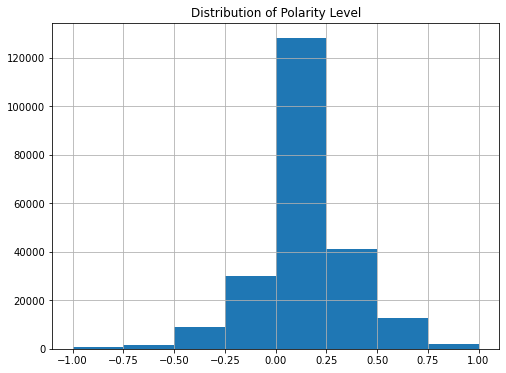

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram for sentiment polarity level
df['polarity'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax)

plt.title('Distribution of Polarity Level')
# plt.show()
plt.savefig('Distribution of Polarity.png')

Most of the polarity scores are between 0 and 0.25.

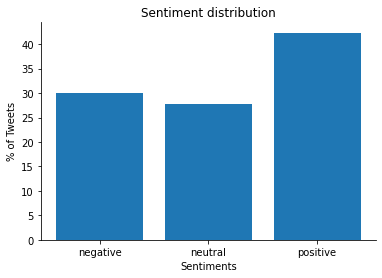

Class imbalance: [0.3  0.28 0.42]


In [20]:
# Plot histogram for sentiment distribution

values, counts = np.unique(df['sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_counts * 100)
plt.xlabel('Sentiments')
plt.ylabel('% of Tweets')
sns.despine()
plt.title('Sentiment distribution')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

Based on these histograms, the overall sentiments from the Covid-19 vaccine tweets are more positive.

**Let's put it into a nice pie chat**

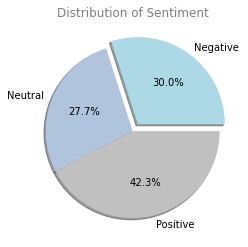

In [21]:
plt.pie(normalized_counts,
        labels =  ['Negative', 'Neutral', 'Positive'],
        autopct='%1.1f%%',
        shadow = True,
        colors = ['lightblue', 'lightsteelblue', 'silver'],
        explode = (0.1, 0, 0))

#plt.legend()
plt.title('Distribution of Sentiment', color = 'grey')

#plt.show()
plt.savefig('Distribution of Sentiment.png')

### Overall Sentiment Change over Time

In [32]:
from IPython.core.display import HTML

In [33]:
%%HTML 
<div class='tableauPlaceholder' id='viz1621225170946' style='position: relative'><noscript><a href='#'><img alt='Overall Sentiment Change ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Se&#47;SentimentAnalysisofCOVID-19VaccineTweets&#47;OverallSentimentChange&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='SentimentAnalysisofCOVID-19VaccineTweets&#47;OverallSentimentChange' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Se&#47;SentimentAnalysisofCOVID-19VaccineTweets&#47;OverallSentimentChange&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1621225170946');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

According to the chart above, the subjectively level being steadily on average overtime. With the development of COVID-19 vaccines, people’s feelings (polarity level) became more positive on average.

### Tweets Counts and Responds over Time

In [34]:
%%HTML
<div class='tableauPlaceholder' id='viz1621225863643' style='position: relative'><noscript><a href='#'><img alt='Likes, Replies, Retweets and Total Tweets ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Se&#47;SentimentAnalysisofCOVID-19VaccineTweets&#47;TweetsCounts&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='SentimentAnalysisofCOVID-19VaccineTweets&#47;TweetsCounts' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Se&#47;SentimentAnalysisofCOVID-19VaccineTweets&#47;TweetsCounts&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1621225863643');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### Negative Sentiment vs Positive Sentiment

In [35]:
%%HTML
<div class='tableauPlaceholder' id='viz1621225923818' style='position: relative'><noscript><a href='#'><img alt='Neg_vs_Pos ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Se&#47;SentimentAnalysisofCOVID-19VaccineTweets&#47;Neg_vs_Pos&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='SentimentAnalysisofCOVID-19VaccineTweets&#47;Neg_vs_Pos' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Se&#47;SentimentAnalysisofCOVID-19VaccineTweets&#47;Neg_vs_Pos&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1621225923818');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

To further investigating the reason behind peoples sentiment, the following analysis will focus on comparing the negative and positive tweets.

In [41]:
df_neg = df[df['sentiment']=='negative']
df_pos = df[df['sentiment']=='positive']

In [42]:
df_neg.describe()

,replies_count,retweets_count,likes_count,polarity,subjectivity
count,66994.000000,66994.000000,66994.000000,66994.000000,66994.000000
mean,0.950488,1.835463,9.954339,-0.015281,0.419020
std,9.918312,46.688742,393.491603,0.242283,0.281951
min,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,0.000000,0.000000,0.000000,-0.122599,0.200000
50%,0.000000,0.000000,0.000000,0.000000,0.450000
75%,1.000000,0.000000,2.000000,0.104545,0.600000
max,1431.000000,6985.000000,91578.000000,1.000000,1.000000


In [43]:
df_pos.describe()

,replies_count,retweets_count,likes_count,polarity,subjectivity
count,95982.000000,95982.000000,95982.000000,95982.000000,95982.000000
mean,0.730689,1.506657,9.535069,0.180526,0.423083
std,8.302804,52.332549,391.528693,0.227623,0.258857
min,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.266667
50%,0.000000,0.000000,0.000000,0.166667,0.437500
75%,1.000000,0.000000,3.000000,0.300000,0.583333
max,1666.000000,10981.000000,87482.000000,1.000000,1.000000


Seems like there negative tweets receiving more replies, more reweets but less likes than positive tweets on average.

Let's see what are the most popular negative tweets talk about.

In [44]:
display(df_neg[df_neg['replies_count'] == max(df_neg['replies_count'])])
display(df_neg[df_neg['retweets_count'] == max(df_neg['retweets_count'])])
display(df_neg[df_neg['likes_count'] == max(df_neg['likes_count'])])

,date,tweet,replies_count,retweets_count,likes_count,polarity,subjectivity,sentiment,covid_update
61565,2021-05-03,my friends sister told me in january that i was crazy for taking the vaccine i just found out she died of covid last night,1431,3077,11570,-0.3,0.483333,negative,NaN


,date,tweet,replies_count,retweets_count,likes_count,polarity,subjectivity,sentiment,covid_update
1971,2021-05-13,so if youre fully vaccinated you can still contract covid it just wont hospitalize or kill you if you can contact covid you can spread it so why the fuck are they saying vaccinated people dont have to wear masks,71,6985,23171,-0.4,0.6,negative,NaN


,date,tweet,replies_count,retweets_count,likes_count,polarity,subjectivity,sentiment,covid_update
99312,2021-04-21,i was supposed to get my vaccine today but i woke up feeling awful and got tested i got covid the day before my vaccine fml,253,1285,91578,-1.0,1.0,negative,EMA Gives Go-Ahead for J&J to Resume Vaccination


We found that the negative tweets mention the COVID-19 vaccines are not necessary implying people negative reaction against the vaccine itself, the negative emotion could also came from personal experience.

Let's see what are the most popular positive tweets talk about.

In [45]:
display(df_pos[df_pos['replies_count']==max(df_pos['replies_count'])])
display(df_pos[df_pos['retweets_count']==max(df_pos['retweets_count'])])
display(df_pos[df_pos['likes_count']==max(df_pos['likes_count'])])

,date,tweet,replies_count,retweets_count,likes_count,polarity,subjectivity,sentiment,covid_update
223926,2020-03-28,ive been admitted into the 1st covid19 vaccine trial im grateful for my health for the 1000s of scientists who brought us here for the team that developed this vaccine tx et al for and the nurse who came out of retirement to draw my blood,1666,10981,52391,0.1,0.3,positive,Trump Signs CARES Act Into Law


,date,tweet,replies_count,retweets_count,likes_count,polarity,subjectivity,sentiment,covid_update
223926,2020-03-28,ive been admitted into the 1st covid19 vaccine trial im grateful for my health for the 1000s of scientists who brought us here for the team that developed this vaccine tx et al for and the nurse who came out of retirement to draw my blood,1666,10981,52391,0.1,0.3,positive,Trump Signs CARES Act Into Law


,date,tweet,replies_count,retweets_count,likes_count,polarity,subjectivity,sentiment,covid_update
211909,2020-11-17,if the pfizer vaccine is 90 effective and the moderna vaccine is 95 effective then just take both 185 effective covids a goner,78,5389,87482,0.6,0.8,positive,"Moderna Reveals Vaccine Efficacy Results, FDA to Move Rapidly on EUAs for Pfizer, Moderna Vaccines"


The positive tweet that getting the most likes talking the same topic as the COVID update, this implies how people’s sentiment responded on COVID update reflects on twitter.

### Most Frequent Words

#### Custom Tokenizer

In [46]:
# Import Natural Language Toolkit packages 

import nltk
from nltk.corpus import stopwords 
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rachelchen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rachelchen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rachelchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Create a customize tokenizer.

In [47]:
nltk.download('stopwords')
stemmer = nltk.PorterStemmer()
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word != ''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rachelchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
# Tokenize the words
neg_words = df_neg['tweet'].apply(lambda x: my_tokenizer(x)).to_list()
neg_words

[['butt',
  'watch',
  'reach',
  'bit',
  'tire',
  'moron',
  'wear',
  'mask',
  'vaccin',
  'complain',
  'covid',
  'restrict',
  'might',
  'say',
  'reason',
  'viru',
  'mutat'],
 ['actual',
  'make',
  'feel',
  'littl',
  'sick',
  'think',
  'mani',
  'peopl',
  'az',
  'vaccin',
  'cancel',
  'book',
  'vaccin',
  'appt',
  'full',
  'knowledg',
  'risk',
  'may',
  'contract',
  'covid',
  'easilyquickli',
  'get',
  'mrna',
  'great'],
 ['vaccin',
  'garbag',
  'know',
  '4',
  'famili',
  'fulli',
  'vaccin',
  'got',
  'covid',
  'right',
  'afterward',
  'wore',
  'mask',
  'etc',
  'fauci',
  'suck'],
 ['guidanc',
  'increas',
  'covid',
  'risk',
  'everi',
  'indoor',
  'space',
  'peopl',
  'cant',
  'vaccin',
  'yet',
  'kid',
  'immun',
  'compris',
  'bc',
  'real',
  'world',
  'mani',
  'unvaccin',
  'lie',
  'unfairli',
  'shift',
  'risk',
  'peopl',
  'vaccin',
  'access',
  'refus'],
 ['space',
  'area',
  'state',
  'less',
  '75',
  'fulli',
  'vaccin',


In [49]:
# Join the words back to together 
for i in range(len(neg_words)):   
    neg_words[i] = ' '.join(neg_words[i])    

neg_words

['butt watch reach bit tire moron wear mask vaccin complain covid restrict might say reason viru mutat',
 'actual make feel littl sick think mani peopl az vaccin cancel book vaccin appt full knowledg risk may contract covid easilyquickli get mrna great',
 'vaccin garbag know 4 famili fulli vaccin got covid right afterward wore mask etc fauci suck',
 'guidanc increas covid risk everi indoor space peopl cant vaccin yet kid immun compris bc real world mani unvaccin lie unfairli shift risk peopl vaccin access refus',
 'space area state less 75 fulli vaccin right thing opinion still id hate see increas spread show new variant deadli caus long covid syndrom',
 'accord nyt 7 week averag covid death 600 insignific still mani mani peopl risk havent gotten vaccin yet cant',
 'pretti sick suck covid dont worri meant ive take easi reschedul vaccin unabl much exercis there one thing that get listen sea shanti',
 'def gonna late stream tonight get second dose covid vaccin im stuck downtown grow traf

In [50]:
# create a funciton for count words
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

/Users/rachelchen/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


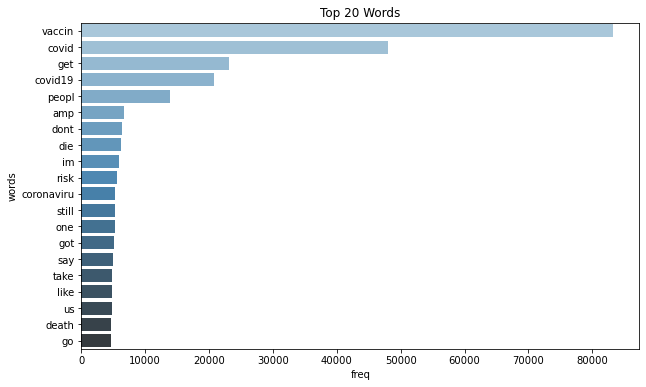

In [51]:
# Create a funtion to plot the most frequent words
def plot_most_frequent(wordlist):
    str = ' '.join(wordlist)
    words = word_count(str)
    words_freq = pd.DataFrame(words.items())
    words_freq.columns=['words','freq']
    words_freq=words_freq.sort_values(by='freq',ascending=False)
    top20 = words_freq.iloc[0:20]
    top20
    plt.figure(figsize=(10,6))
    sns.barplot('freq', 'words', data=top20, palette='Blues_d').set_title('Top 20 Words')
    plt.show()

plot_most_frequent(neg_words)

Let's stop the words `covid`, `coronaviru`, `covid19`, `vaccin`, `amp` for following analysis because they are either the search terms showing in every tweets or not meaningful.

#### Word Cloud

In [57]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def word_cloud(wd_list, wd_color):
    stopwords = set(STOPWORDS)
    stopwords.update(['covid', 'coronaviru', 'covid19', 'vaccin', 'amp'])
    all_words = ' '.join([text for text in wd_list])
    
    wordcloud = WordCloud(
        background_color = 'white',
        colormap = wd_color,
        stopwords=stopwords,
        width = 1600,
        height = 800,
        random_state = 1,
        max_words = 300,
        min_word_length = 3,
        max_font_size = 200).generate(all_words)
    
    plt.figure(figsize = (12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear")

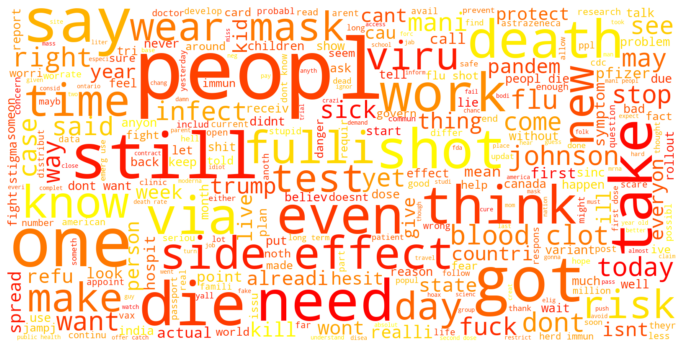

In [58]:
word_cloud(neg_words, 'autumn')
plt.savefig('neg_wordcloud.png')

The wordcloud shows the most frequent words regarding vaccines in negative tweets are things related to death or side effects.

#### Repeat for Positive Words

In [54]:
pos_words = df_pos['tweet'].apply(lambda x: my_tokenizer(x)).to_list()

/Users/rachelchen/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


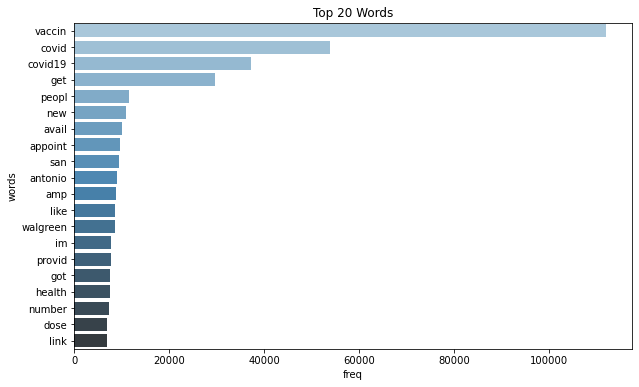

In [55]:
for i in range(len(pos_words)):   
    pos_words[i] = ' '.join(pos_words[i])    

plot_most_frequent(pos_words)

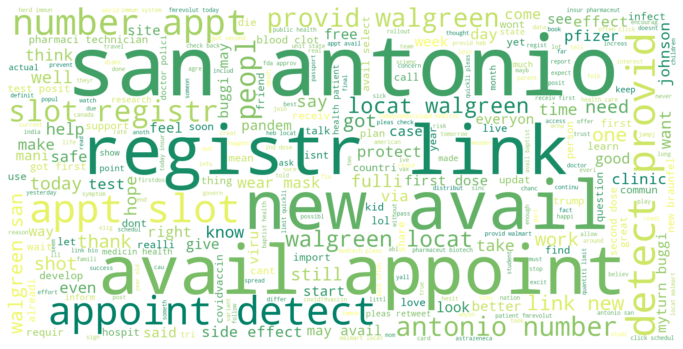

In [59]:
word_cloud(pos_words, 'summer')
plt.savefig('pos_wordcloud.png')

The wordcloud shows the most frequent words regarding vaccines in positive tweets are things related to vaccine appointment or registration. 

## 2. Modeling

### Topic Modeling by LDA

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
stopwords.extend(['covid', 'coronaviru', 'covid19', 'vaccin', 'amp'])

# TF-IDF vectorization
tfidf = TfidfVectorizer(min_df = 5,
                        max_df = 0.95, # drop words that occur in at least 95% of the documents
                        tokenizer = my_tokenizer,
                        stop_words = stopwords)

news_transformed = tfidf.fit_transform(df_neg['tweet'])

news_transformed.shape

(66994, 8956)

In [62]:
from sklearn.decomposition import LatentDirichletAllocation

# fit the LDA topic model
lda = LatentDirichletAllocation(n_components = 5, 
                                random_state = 1
                               )
lda.fit(news_transformed)

LatentDirichletAllocation(n_components=5, random_state=1)

In [63]:
# for each topic, print the the top 10 most representative words
words = tfidf.get_feature_names()

for i, topic in enumerate(lda.components_):
    topic_words = ' '.join([words[j] for j in topic.argsort()[: -11: -1]])
    print(f'Topic #{i} words: {topic_words}')

Topic #0 words: johnson emerg health use via pfizer fight card fda new
Topic #1 words: trump get biden us peopl countri via need world say
Topic #2 words: get peopl dont mask im still go wear take want
Topic #3 words: got get day im dose second today shot first appoint
Topic #4 words: risk peopl die get death clot blood effect infect case


Let's guess what's the topic about:
- Topic 0: Vaccine Brands
- Topic 1: Politics
- Topic 2: Masks
- Topic 3: Shot Appointment 
- Topic 4: Side Effects

In [66]:
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
stopwords.extend(['covid', 'coronaviru', 'covid19', 'vaccin', 'amp'])

# TF-IDF vectorization
tfidf = TfidfVectorizer(min_df = 5,
                        max_df = 0.95, # drop words that occur in at least 95% of the documents
                        tokenizer = my_tokenizer,
                        stop_words = stopwords)

news_transformed = tfidf.fit_transform(df_pos['tweet'])

news_transformed.shape

(95982, 11609)

In [67]:
from sklearn.decomposition import LatentDirichletAllocation

# fit the LDA topic model
lda = LatentDirichletAllocation(n_components = 5, 
                                random_state = 1
                               )
lda.fit(news_transformed)

LatentDirichletAllocation(n_components=5, random_state=1)

In [68]:
# for each topic, print the the top 10 most representative words
words = tfidf.get_feature_names()

for i, topic in enumerate(lda.components_):
    topic_words = ' '.join([words[j] for j in topic.argsort()[: -11: -1]])
    print(f'Topic #{i} words: {topic_words}')

Topic #0 words: get got first today thank dose im shot second feel
Topic #1 words: clinic appoint free schedul pleas elig avail health counti may
Topic #2 words: get peopl like dont still im mask effect immun take
Topic #3 words: approv johnson pfizer us fda use health via recommend say
Topic #4 words: san antonio walgreen new provid registr locat detect avail slot


Let's guess what's the topic about:
- Topic 0: Shot Experience 
- Topic 1: Vaccine appointment
- Topic 2: Immunity 
- Topic 3: Vaccine Brands
- Topic 4: Local Roll Out

### N-grams

N-grams words might provide a better view than single word of what exactly people are talking about

In [69]:
#Function to ngram
def get_top_n_gram(corpus, tokenizer, stop_words, ngram_range, n = None):
    
    vec = CountVectorizer(min_df = 5,
                          ngram_range = ngram_range,
                          tokenizer = tokenizer,
                          stop_words = stop_words).fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
   
    return words_freq[:n]

In [70]:
#n2_bigram
n2_bigrams = get_top_n_gram(df_neg['tweet'], my_tokenizer, stopwords, (2,2), 10)
n2_bigrams

/Users/rachelchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[('side effect', 2047),
 ('wear mask', 1933),
 ('blood clot', 1742),
 ('johnson johnson', 1237),
 ('peopl die', 931),
 ('peopl get', 912),
 ('fight stigma', 836),
 ('dont want', 833),
 ('still get', 771),
 ('flu shot', 768)]

In [71]:
#n2_bigram
n2_bigrams = get_top_n_gram(df_pos['tweet'], my_tokenizer, stopwords, (2,2), 10)
n2_bigrams

[('san antonio', 9042),
 ('avail appoint', 5660),
 ('registr link', 5619),
 ('new avail', 5611),
 ('appoint detect', 5607),
 ('detect provid', 5607),
 ('appt slot', 5550),
 ('number appt', 5549),
 ('antonio number', 4493),
 ('provid walgreen', 4193)]

In [72]:
#n3_trigram
n3_trigrams = get_top_n_gram(df_neg['tweet'], None, stopwords, (3,3),10)
n3_trigrams

[('johnson johnson vaccine', 668),
 ('vaccine side effects', 326),
 ('todaysmedicalupdate medicine health', 277),
 ('medicine health patients', 277),
 ('health patients nhs', 277),
 ('patients nhs fmrevolution', 277),
 ('nhs fmrevolution today', 277),
 ('fmrevolution today insurance', 277),
 ('today insurance pharmaceutical', 277),
 ('insurance pharmaceutical biotech', 277)]

In [73]:
#n3_trigram
n3_trigrams = get_top_n_gram(df_pos['tweet'], None, stopwords, (3,3),10)
n3_trigrams

[('new available appointments', 5607),
 ('available appointments detected', 5607),
 ('appointments detected provider', 5607),
 ('number appt slots', 5549),
 ('san antonio number', 4493),
 ('antonio number appt', 4493),
 ('detected provider walgreens', 4193),
 ('provider walgreens location', 4193),
 ('walgreens location walgreens', 4193),
 ('location walgreens san', 3381)]

Seems like the negative tweets discussed different issues such as vaccine brands, side effects and death while positive tweets mainly discussed vaccine appointments.

### Bag-of-Words Model

Let's fit a model on tweets with positive or negative sentiment and see how each word affected the sentiment level.

In [74]:
df_model = df[(df['sentiment'] == 'negative') | (df['sentiment'] == 'positive')]

In [75]:
# Encode the sentiment label
df_model['pos'] = np.where(df_model['sentiment'] == 'positive', 1, 0)
df_model.drop(columns = 'sentiment', inplace = True)

<ipython-input-75-034d0a5cf0c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['pos'] = np.where(df_model['sentiment'] == 'positive', 1, 0)
/Users/rachelchen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [76]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162976 entries, 0 to 225800
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            162976 non-null  datetime64[ns]
 1   tweet           162976 non-null  object        
 2   replies_count   162976 non-null  int64         
 3   retweets_count  162976 non-null  int64         
 4   likes_count     162976 non-null  int64         
 5   polarity        162976 non-null  float64       
 6   subjectivity    162976 non-null  float64       
 7   covid_update    115084 non-null  object        
 8   pos             162976 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 12.4+ MB


In [77]:
# Create variable and target features 
X = df_model[['tweet']]
y = df_model['pos']

In [78]:
# splitting our data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify= y, random_state = 1)

In [79]:
# we don't want any number string as variables becuase hard to interpret on the results 
import re

def remove_num(tokens):
    i = re.sub('(\d)+', 'NUM', tokens.lower())
    return i

In [80]:
from sklearn.feature_extraction.text import CountVectorizer

# 1. Instantiate
bagofwords = CountVectorizer(preprocessor = remove_num,
                             stop_words='english',
                             min_df = 5, max_df = 0.95, 
                             tokenizer = my_tokenizer)

# 2. Fit
bagofwords.fit(X_train['tweet'])

# 3. Transform
X_train_transformed = bagofwords.transform(X_train['tweet'])
X_test_transformed = bagofwords.transform(X_test['tweet'])

X_train_transformed.shape

/Users/rachelchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/Users/rachelchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'ther

(114083, 11196)

In [81]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
df_train = pd.DataFrame(columns = bagofwords.get_feature_names(), data = X_train_transformed.toarray())
df_train.head()

,aa,aacrnum,aampm,aap,aapi,aaron,aarp,ab,abandon,abat,...,zipcod,znum,zoe,zombi,zone,zoo,zoom,zoster,zs,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Logistic Regression

In [82]:
from sklearn.linear_model import LogisticRegression

# Fitting a model
logreg = LogisticRegression(C = 0.1)
logreg.fit(X_train_transformed, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train_transformed, y_train)}")
print(f"Test score: {logreg.score(X_test_transformed, y_test)}")

Train score: 0.8812969504658889
Test score: 0.8682633505818829


/Users/rachelchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The model looks good, let's also try a Naive Bayes Classification.

#### Naive Bayes Classification

In [83]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

# Instatiate our model
nbmodel = BernoulliNB()
# Fit our model
nbmodel.fit(X_train_transformed, y_train)

BernoulliNB()

In [84]:
print(nbmodel.predict_proba(X_test_transformed) )#get probabilistic prediction
print(nbmodel.predict(X_test_transformed) )#get hard prediction

[[9.51249211e-01 4.87507894e-02]
 [7.93501883e-19 1.00000000e+00]
 [1.47671822e-18 1.00000000e+00]
 ...
 [9.98696622e-01 1.30337797e-03]
 [1.92104924e-01 8.07895076e-01]
 [9.99961398e-01 3.86024317e-05]]
[0 1 1 ... 0 1 0]


In [85]:
nbmodel.feature_count_ 

array([[ 4., 13.,  2., ..., 14.,  8.,  8.],
       [ 2.,  1.,  4., ...,  9.,  1.,  2.]])

In [86]:
print('train score:', nbmodel.score(X_train_transformed, y_train))
print('test score:', nbmodel.score(X_test_transformed, y_test))

train score: 0.779318566306987
test score: 0.7646493363058107


Let's continue with Logistic Regression because it performs better on test set.

#### Hyperparameter Optimization

In [87]:
# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp

# To build a pipeline
from sklearn.pipeline import Pipeline

# To try scaling the data in various ways
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# To try dimensionality reduction
from sklearn.decomposition import PCA

# To do a cross-validated grid search
from sklearn.model_selection import GridSearchCV

#To print classification report
from sklearn.metrics import classification_report

# To get rid of logistic regression default solver warnings that appear if sklearn hasn't been updated
import warnings
warnings.filterwarnings('ignore')

In [88]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()
# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline([('scaler', StandardScaler()), ('dim_reducer', PCA()), ('model', LogisticRegression())], memory=cachedir)

In [89]:
# Let's try the same range of C values from earlier
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000, 10000]

# Parameter grid
logreg_param_grid = [
    
    # l1 without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l1 with PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l2 (default) without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l2 (default) with PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values}
]

In [90]:
# Instantiate the log reg grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the log reg grid search
fitted_logreg_gs = logreg_gs.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


In [91]:
fitted_logreg_gs.best_estimator_

Pipeline(memory='/var/folders/dq/6k9gjtrd1hvg9cplmb1wn0t00000gp/T/tmpgpk5l50p',
         steps=[('scaler', None), ('dim_reducer', None),
                ('model', LogisticRegression(C=1, n_jobs=-1, random_state=1))])

In [92]:
# Print the accuracies
print(f"The best logistic regression's accuracy on the train set: {fitted_logreg_gs.score(X_train_transformed, y_train)}")
print(f"The best logistic regression's accuracy on the test set: {fitted_logreg_gs.score(X_test_transformed, y_test)}")

The best logistic regression's accuracy on the train set: 0.896759376944856
The best logistic regression's accuracy on the test set: 0.8722516515656638


Test result is better than our baseline model now.

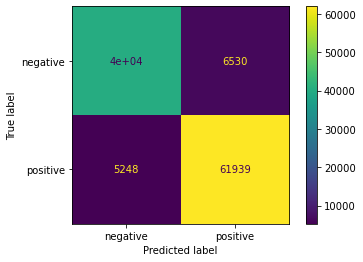

In [93]:
# Train set confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_train_preds = fitted_logreg_gs.predict(X_train_transformed)

conf_matrix = confusion_matrix(y_train, y_train_preds)

ConfusionMatrixDisplay(conf_matrix, display_labels= ['negative', 'positive']).plot()

In [94]:
y_pred = fitted_logreg_gs.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84     20098
           1       0.88      0.90      0.89     28795

    accuracy                           0.87     48893
   macro avg       0.87      0.87      0.87     48893
weighted avg       0.87      0.87      0.87     48893



The model has done not bad across all the classes, there are still some issues with precision for both class 0 and 1. For some of the points (1) we predicted as being positive, they actually belonged to class negative. For some of the points (0) we predicted as being negative, they actually belonged to class positive.

#### Coefficient Interpretation

In [95]:
coefs = fitted_logreg_gs.best_estimator_.named_steps['model'].coef_.flatten()

In [96]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(df_train.columns, coefs)
df_coefs = pd.DataFrame(zipped, columns=['feature', 'value'])

# Sort the features by the absolute value of their coefficient
df_coefs = df_coefs.sort_values(by = 'value', key = abs, ascending = False)

In [97]:
df_coefs.head(10)

,feature,value
950,bitter,-5.862823
4345,hell,-3.254329
2653,disappoint,-3.212649
7927,racism,-3.095669
656,awesom,3.074644
2401,dead,-3.055388
2212,crisi,-3.001370
11115,yay,2.922243
2655,disast,-2.901122
11012,woohoo,2.852057


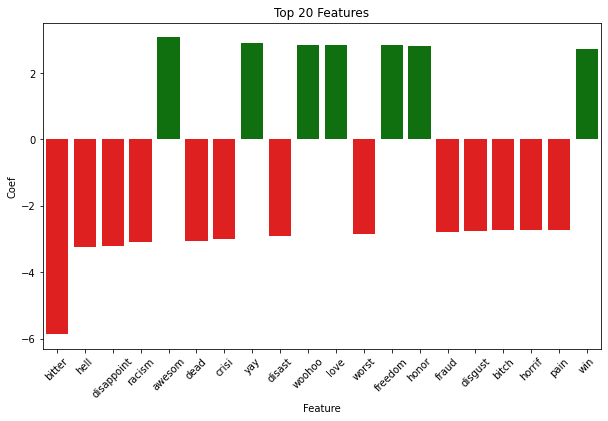

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(x = 'feature',
            y = 'value',
            data = df_coefs.head(20),
            palette = (df_coefs.head(20)['value'] > 0).map({True: 'green', False: 'red'}))

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set_title('Top 20 Features')
ax.set_ylabel('Coef')
ax.set_xlabel('Feature')

#plt.show()
plt.savefig('TopFeatures')

I want to see how some specific term relate to sentiment.

In [99]:
df_coefs[df_coefs['feature'].isin(['pfizer','biontech','moderna', 'janssen', 'astrazeneca'])].sort_values(by = 'value', ascending = False)

,feature,value
930,biontech,0.692224
5073,janssen,0.249713
6201,moderna,0.185746
7341,pfizer,0.112177
544,astrazeneca,-0.084915


For vaccine brand, Biotech has the most positive correlation with the positive sentiment while AstraZeneca has the least. 

In [100]:
df_coefs[df_coefs['feature'].isin(['trudeau','trump','biden', 'ford', 'fauci'])].sort_values(by = 'value', ascending = False)

,feature,value
896,biden,0.095147
3419,fauci,-0.106867
3644,ford,-0.168225
10104,trump,-0.170016
10097,trudeau,-0.208217


For politician, Biden has the most positive correlation with the positive sentiment while ford has the most negative correlation

## 3. Conclusion 
This project found that people's reactions or emotions on COVID-19 updates would reflect on Twitter. The results show that people concern about the side effect and specific vaccine brands, and they tend to post positive tweets when they got the vaccine or made an appointment. Suppose the government develops resources that promote the understanding of and confidence in COVID-19 vaccines. And also speed up their process. More people will get their vaccination done and end the pandemic soon. The next step of this project is to build a daily sentiment monitor product to present the results.